In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import BallTree
import copy
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.figure_factory as ff

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
folder = "../00_Raw_Data/"

# Generate filenames from 2015_Q1 to 2022_Q4
years = range(2015, 2023)
quarters = range(1, 5)

files = ["{}_Q{}_Traffic_Crashes.csv".format(year, quarter) for year in years for quarter in quarters]

dfs = [pd.read_csv(folder + file) for file in files]
df = pd.concat(dfs, ignore_index=True)

In [4]:
df['collision_date'] = pd.to_datetime(df['collision_date'], format='%m/%d/%Y %I:%M:%S %p')
df['date'] = df['collision_date'].dt.date

df['day_of_week'] = df['collision_date'].dt.dayofweek # 0: Monday - 6: Sunday

df['time'] = df['collision_date'].dt.time
df['hour'] = df['collision_date'].dt.hour
df['month'] = df['collision_date'].dt.month
df['year'] = df['collision_date'].dt.year
df['covid'] = (df['date'] >= pd.Timestamp('2020-03-15').date()).astype(int)

columns_to_convert = ['pedestrian', 'bicycle', 'scooter', 'hitrun', 'parking']

for column in columns_to_convert:
    df[column] = df[column].map({'yes': 1, 'no': 0})
    
df['manner_of_crash'] = df['manner_of_crash'].fillna('Unknown/Missing')
df['manner_of_crash'] = df['manner_of_crash'].replace(['Missing', 'Unknown'], 'Unknown/Missing')
encoder = LabelEncoder()

df['manner_of_crash'] = encoder.fit_transform(df['manner_of_crash'])

df['roadway_name'] = df['roadway_name'].fillna('UNKNOWN')
df['roadway_name'] = df['roadway_name'].replace(['UNNAMED ROAD', 'UNNAMED STREET', '-- UNKNOWN RAMP/ROAD --'], 'UNKNOWN')
roadway_encoder = LabelEncoder()
df['roadway_name'] = roadway_encoder.fit_transform(df['roadway_name'])

df['intersection_indicator'] = df['intersection_indicator'].fillna("N")
df['intersection_indicator'].replace("Missing", "N", inplace=True)
mapping = {"N": 0, "Y": 1}
df['intersection_indicator'] = df['intersection_indicator'].map(mapping)
df['intersection_indicator'] = df['intersection_indicator'].astype('int64')

df['intersect_type'] = df['intersect_type'].fillna('Unknown/Other')
df['intersect_type'].replace(['OTHER', 'Missing', 'Unknown'], 'Unknown/Other', inplace=True)
intersect_type_encoder = LabelEncoder()
df['intersect_type'] = intersect_type_encoder.fit_transform(df['intersect_type'])

df['relation_to_junction'] = df['relation_to_junction'].fillna('Unknown/Other')
df['relation_to_junction'].replace(['Missing', 'OtherLocation', 'Unknown'], 'Unknown/Other', inplace=True)
relation_to_junction_encoder = LabelEncoder()
df['relation_to_junction'] = relation_to_junction_encoder.fit_transform(df['relation_to_junction'])

df['mou'] = df['mou'].replace('OHO', 'Campus')
df['mou'] = df['mou'].apply(lambda x: 1 if x == 'Campus' else 0)

df['work_zone_type'] = df['work_zone_type'].apply(lambda x: 0 if x == "Missing" or x == "Unknown" else 1)

def simplify_weather(weather):
    if pd.isna(weather):
        return 'Unknown/Other'
    elif 'Snow' in weather:
        return 'Snow'
    elif 'Sleet/Hail' in weather:
        return 'Sleet/Hail'
    elif 'Rain' in weather:
        return 'Rain'
    elif weather in ['Fog', 'Smoke', 'Smog']:
        return 'Fog'
    elif 'Cloudy' in weather:
        return 'Cloudy'
    elif weather == 'Clear':
        return 'Clear'
    elif weather in ['Missing', 'Unknown', 'Other']:
        return 'Unknown/Other'
    else:
        return 'Other Conditions'

df['weather_condition(s)'] = df['weather_condition(s)'].apply(simplify_weather)
simplified_weather_encoder = LabelEncoder()
df['weather_condition(s)'] = simplified_weather_encoder.fit_transform(df['weather_condition(s)'])

df['city'] = df['city'].fillna('Unknown')
city_encoder = LabelEncoder()
df['city'] = city_encoder.fit_transform(df['city'])

def bool_to_int(df):
    for col in df.select_dtypes(['bool']).columns:
        df[col] = df[col].astype(int)
    return df

df = bool_to_int(df)

def categorize_time_window(hour):
    if 6 <= hour <= 9:
        return 'rush_morning'
    elif 15 <= hour <= 18:
        return 'rush_evening'
    elif 10 <= hour <= 14:
        return 'non_rush_day'
    else:  
        return 'non_rush_night'

df['time_window'] = df['hour'].apply(categorize_time_window)


df['time'] = df['time'].astype(str)
df['time'] = df['time'].str.strip()
has_time_df = df[df['time'] != "00:00:00"]

weekday_df = has_time_df[has_time_df['day_of_week'].between(0, 4)].copy()  

weekday_df = weekday_df.sample(frac=1, random_state=42).reset_index(drop=True)

time_window_mapping = {
    'rush_morning': 0,
    'rush_evening': 1,
    'non_rush_day': 2,
    'non_rush_night': 3
}

weekday_df['time_window'] = weekday_df['time_window'].replace(time_window_mapping)

In [5]:
columns_to_drop = [
    "agency", "agency_tracking_number", "county",
    "collision_date", "roadway_suffix", "roadway_number", "roadway_local_id",
    "distance_from_reference", "miles-feet_indicator", "direction_from_reference",
    "intersection_road_name", "intersection_road_name_suffix", "intersection_road_number",
    "intersection_local_id", "mile_marker", "interchange_related_indicator",
    "construction_maintenance_zone", "construction_maintenance_zone_location",
    "fatal_case_number", "officer_first_name", "officer_last_name", "date", "time", "hour"
]

weekday_df = weekday_df.drop(columns=columns_to_drop, axis=1)

In [10]:
has_time_df = copy.deepcopy(weekday_df)

train_val, test = train_test_split(has_time_df, test_size=0.1, stratify=has_time_df['time_window'], random_state=42)
train, val = train_test_split(train_val, test_size=2/9, stratify=train_val['time_window'], random_state=42) 

tree = BallTree(train[['latitude', 'longitude']].values)

def calculate_mode_time_window_of_nearest(train_tree, train_data, point, k=4):
    dist, ind = train_tree.query(point, k=k)
    time_windows = train_data.iloc[ind[0]]['time_window']
    if len(time_windows) < k: 
        return np.nan
    return mode(time_windows).mode[0] 

has_time_df['most_common_time_window_4_neigh'] = has_time_df.apply(
    lambda row: calculate_mode_time_window_of_nearest(
        tree, 
        train[['time_window']],  
        np.array([[row['latitude'], row['longitude']]]),
    ), 
    axis=1
)
# Make sure 'master_record_number' is set as the index for the merge operation if it's not already the index
df_with_avg_hour = has_time_df.set_index('master_record_number')[['most_common_time_window_4_neigh']]

# Merge 'avg_hour_4_neigh' into the original train, validation, and test sets using 'master_record_number'
train_with_avg_hour = train.set_index('master_record_number').join(df_with_avg_hour)
val_with_avg_hour = val.set_index('master_record_number').join(df_with_avg_hour)
test_with_avg_hour = test.set_index('master_record_number').join(df_with_avg_hour)

# Reset the index if required to bring 'master_record_number' back to columns
train_with_avg_hour = train_with_avg_hour.reset_index()
val_with_avg_hour = val_with_avg_hour.reset_index()
test_with_avg_hour = test_with_avg_hour.reset_index()

train_mlp = train_with_avg_hour.drop(['master_record_number'], axis=1).copy()
val_mlp = val_with_avg_hour.drop(['master_record_number'], axis=1).copy()
test_mlp = test_with_avg_hour.drop(['master_record_number'], axis=1).copy()

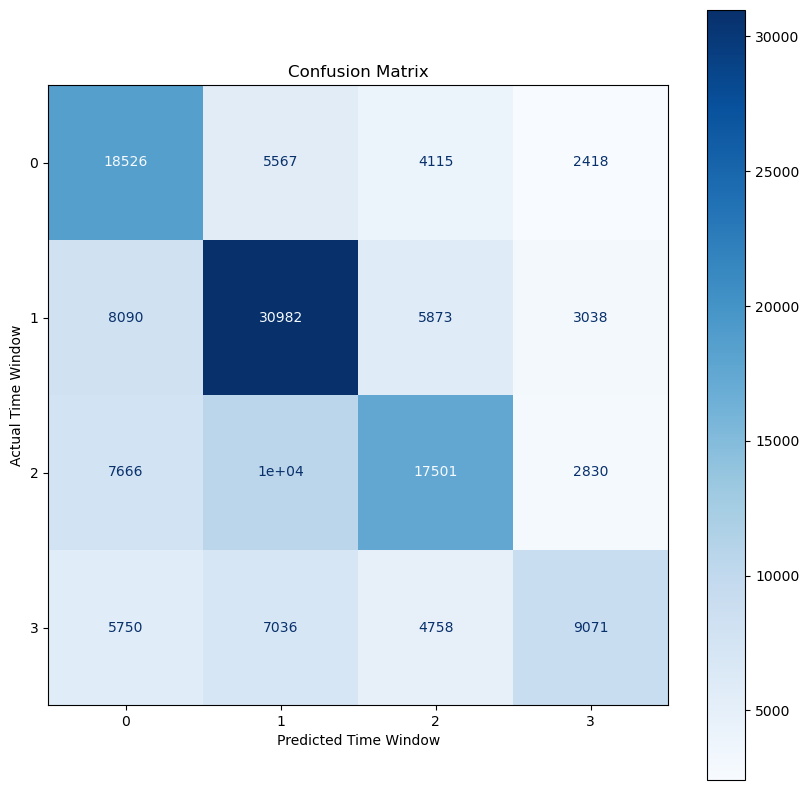

In [11]:
cm = confusion_matrix(train_mlp['time_window'], train_mlp['most_common_time_window_4_neigh'])

cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(train_mlp['time_window']))

fig, ax = plt.subplots(figsize=(10, 10))
cmd.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title('Confusion Matrix')
plt.xlabel('Predicted Time Window')
plt.ylabel('Actual Time Window')
plt.show()

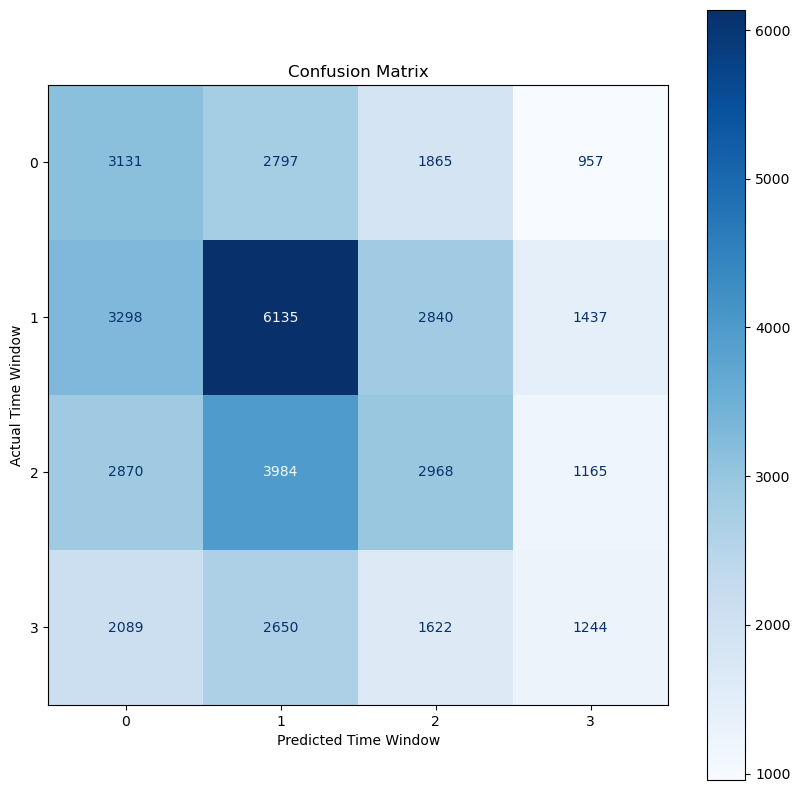

In [12]:
cm = confusion_matrix(val_mlp['time_window'], val_mlp['most_common_time_window_4_neigh'])

cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(val_mlp['time_window']))

fig, ax = plt.subplots(figsize=(10, 10))
cmd.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title('Confusion Matrix')
plt.xlabel('Predicted Time Window')
plt.ylabel('Actual Time Window')
plt.show()

In [13]:
train_mlp.to_csv("../03_Data_for_Modeling/train_mlp_new_time_window.csv", index=False)
val_mlp.to_csv("../03_Data_for_Modeling/val_mlp_new_time_window.csv", index=False)
test_mlp.to_csv("../03_Data_for_Modeling/test_mlp_new_time_window.csv", index=False)